In [ ]:
import numpy as np
import pandas as pd

# Datei einlesen und Daten als np array mit gelösche Laufnummern zuückgeben.
def readfiles(myfile):
    data = []
    with open(myfile, "r") as file: 
        for line in file:
            parts = line.strip().split()
            data.append(parts)
    
    data =np.array(data)[ : , 1: ]
        
    return data
        
        
# In ein NumPy-Array umwandeln
#Laufende Nummer der Instanz von 0 bis 1999 löschen, weil uns nichts bringt.
r1=readfiles("runtimes.mp80")

print(r1)
print (r1.shape)

        id               start              pre_end          solver_end  \
0        0 2024-05-03 17:11:29  03.05.2024-17:11:36 2024-05-03 17:11:58   
1        1 2024-05-03 17:11:58  03.05.2024-17:12:25 2024-05-03 17:13:03   
2        2 2024-05-03 17:13:03  03.05.2024-17:13:10 2024-05-03 17:13:27   
3        3 2024-05-03 17:13:27  03.05.2024-17:13:33 2024-05-03 17:13:53   
4        4 2024-05-03 17:13:53  03.05.2024-17:14:10 2024-05-03 17:14:35   
...    ...                 ...                  ...                 ...   
1995  1995 2024-05-05 01:41:54  05.05.2024-01:42:07 2024-05-05 01:42:17   
1996  1996 2024-05-05 01:42:17  05.05.2024-01:42:27 2024-05-05 01:42:48   
1997  1997 2024-05-05 01:42:48  05.05.2024-01:42:56 2024-05-05 01:43:36   
1998  1998 2024-05-05 01:43:36  05.05.2024-01:43:44 2024-05-05 01:44:26   
1999  1999 2024-05-05 01:44:26  05.05.2024-01:44:33 2024-05-05 01:44:44   

      runtime_s  
0          29.0  
1          65.0  
2          24.0  
3          26.0  
4        

In [ ]:
#Methode zum Einlesen der Daten und Berechnen der Laufszeiten.

def read_and_compute_runtime(filename):
    df = pd.read_csv(filename, sep=r"\s+", header=None,
                     names=["id", "start", "pre_end", "solver_end"])

    time_format = "%d.%m.%Y-%H:%M:%S"
    df["start"] = pd.to_datetime(df["start"], format=time_format)
    df["solver_end"] = pd.to_datetime(df["solver_end"], format=time_format)
    df["runtime_s"] = (df["solver_end"] - df["start"]).dt.total_seconds()

    return df

r1=read_and_compute_runtime("runtimes.mp80")
print(r1)


        id               start              pre_end          solver_end  \
0        0 2024-05-03 17:11:29  03.05.2024-17:11:36 2024-05-03 17:11:58   
1        1 2024-05-03 17:11:58  03.05.2024-17:12:25 2024-05-03 17:13:03   
2        2 2024-05-03 17:13:03  03.05.2024-17:13:10 2024-05-03 17:13:27   
3        3 2024-05-03 17:13:27  03.05.2024-17:13:33 2024-05-03 17:13:53   
4        4 2024-05-03 17:13:53  03.05.2024-17:14:10 2024-05-03 17:14:35   
...    ...                 ...                  ...                 ...   
1995  1995 2024-05-05 01:41:54  05.05.2024-01:42:07 2024-05-05 01:42:17   
1996  1996 2024-05-05 01:42:17  05.05.2024-01:42:27 2024-05-05 01:42:48   
1997  1997 2024-05-05 01:42:48  05.05.2024-01:42:56 2024-05-05 01:43:36   
1998  1998 2024-05-05 01:43:36  05.05.2024-01:43:44 2024-05-05 01:44:26   
1999  1999 2024-05-05 01:44:26  05.05.2024-01:44:33 2024-05-05 01:44:44   

      runtime_s  
0          29.0  
1          65.0  
2          24.0  
3          26.0  
4        

In [37]:
#Methode aufrufen, Laufzeiten, Mittelwerte, Varianz , median und standardabweichungen  von Jede Prozessor berechnen
# und in einem DataFrame (~ Dictionary ) speichern 


files = {
    "Intel N95 (mp80)": "runtimes.mp80",
    "Intel N100": "runtimes.n100",
    "Raspberry Pi 5": "runtimes.pi5"
}

data = {name: read_and_compute_runtime(path) for name, path in files.items()}

results=[]
for name, df in data.items():
    mean = df["runtime_s"].mean()
    median = df["runtime_s"].median()
    var = df["runtime_s"].var()
    std = df["runtime_s"].std()
    max=df["runtime_s"].max()
    min=df["runtime_s"].min()
    
    
    results.append({'Name': name,'Mean': mean,'Median': median,'Standardabweichung': std, 'Min(Zeit in Sekunden)': min,'Max( Zeit in Sekunden)': max})

# jetz als DataFrame umwandeln
mmvs_df = pd.DataFrame(results)

print(mmvs_df)

               Name      Mean  Median  Standardabweichung  \
0  Intel N95 (mp80)   58.5965    44.0           69.289503   
1        Intel N100   21.9610     4.5           42.905666   
2    Raspberry Pi 5  110.0830    67.0          365.210008   

   Min(Zeit in Sekunden)  Max( Zeit in Sekunden)  
0                    7.0                  1538.0  
1                    0.0                  1518.0  
2                   10.0                 14990.0  


ValueError: ':_' is not a valid value for ls; supported values are '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'

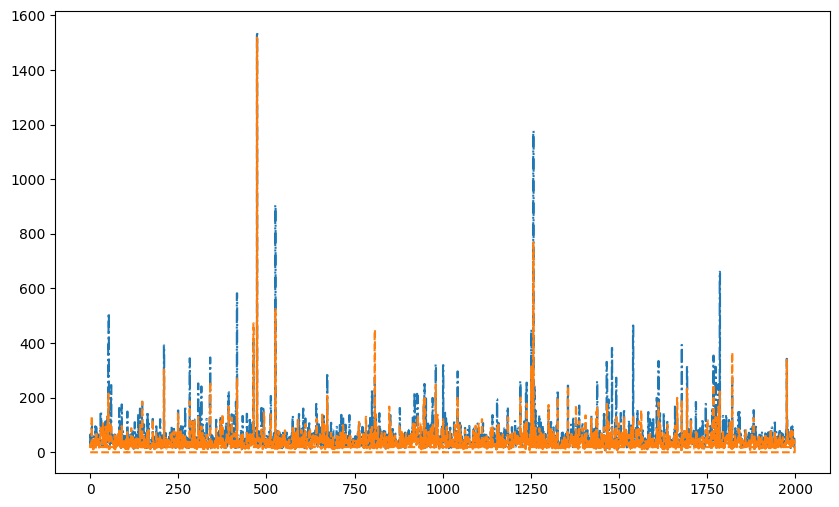

In [ ]:
import matplotlib.pyplot as plt
linestyles = {
    "Intel N95 (mp80)": "-.",
    "Intel N100": "--",
    "Raspberry Pi 5": ":"
}
plt.figure(figsize=(10, 6))
for name, df in data.items():
    plt.step(df["id"], df["runtime_s"], label=name,  linestyle=linestyles.get(name, "solid"))
plt.xlabel("Run-ID")
plt.ylabel("Laufzeit (Sekunden)")
plt.title("Verteilung der Laufzeiten" )
plt.legend()
plt.tight_layout()
plt.savefig("runtime_distribution111.png") 
plt.show()
print (df["id"])